<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.3.1'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
! pip install tensorflow-probability==0.11.0
    

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [8]:
import tensorflow_probability as tfp

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [10]:
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [11]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#### load some SDSS data


In [12]:
import sdss_pae.sdss_dataset as sdss 

In [13]:
ds, info = tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data_large',with_info=True, split='train')

In [14]:
info

tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from spAll and spZbest files 
'flux': measured spectrum in  
'inv_var': inverse variance
'and_mask': and mask (set to 1 for all non-zero entries)
'coeffs': c0, c1, npix. calculate wavelengths with `10.**(c0 + c1 * np.arange(npix))`
'label': type of object, 'STAR'==0, 'QSO'==1, 'GALAXY'==2
'redshift': object redshift estimate',
    homepage='https://www.sdss.org/science/data-release-publications/',
    features=FeaturesDict({
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'filename': Text(shape=(), dtype=tf.string),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'redshift': tf.float32,
    }),
    total_num_examples=200000,
    splits={
        'train': 200000,
    }

In [15]:
# use only galxies for now
select_by = 2
# de-redhsift or not?
de_redshift = True

In [16]:
z_ref  = 0.1
ld_ref = cosmo.luminosity_distance(z_ref)

zs   = np.linspace(0,4,800, dtype=np.float32)
yref = cosmo.luminosity_distance(zs).astype(np.float32)

In [17]:


spline = tfp.math.interp_regular_1d_grid(x=np.logspace(-4,0.5,dtype=np.float32), x_ref_min=0, x_ref_max=4, y_ref=yref)


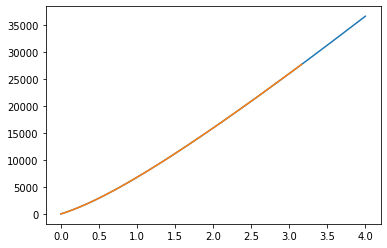

In [18]:
plt.plot(zs, yref)
plt.plot(np.logspace(-4,0.5), spline)

In [19]:

def filter_type_fn(x):
    if select_by is not None:
        return tf.math.equal(x['label'], select_by)
    else: return 1
    
def filter_redshift_fn(x):
    if select_by is not None:
        return tf.math.logical_and(tf.math.greater(x['redshift'], 0.4),tf.math.less(x['redshift'], 1.0))
    else: return 1

ds = ds.filter(filter_type_fn)
ds = ds.filter(filter_redshift_fn)

In [20]:
DATASET_SIZE=len(list(ds))

In [21]:
print(DATASET_SIZE)

85829


In [22]:
(47308*5000*8)/1e9

1.89232

0.5633658 2 0.5633658


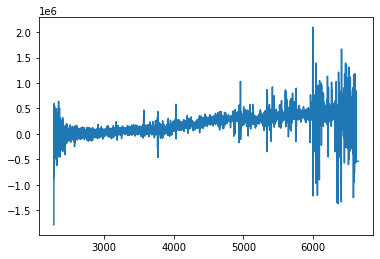

0.7287239 2 0.7287239


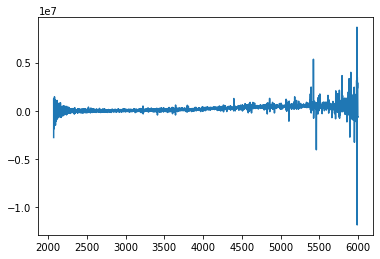

0.80304116 2 0.80304116


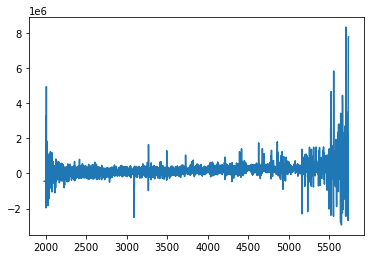

0.57095224 2 0.57095224


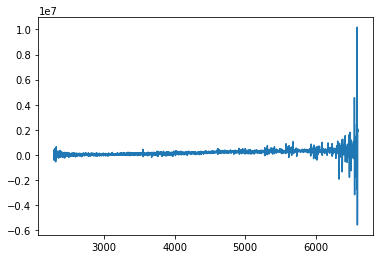

0.53570426 2 0.53570426


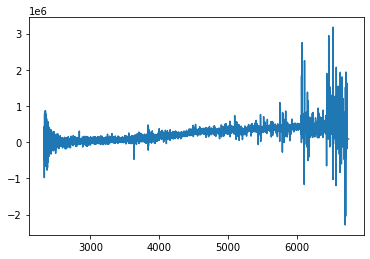

0.7391062 2 0.7391062


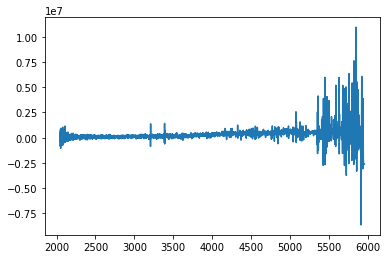

0.53251487 2 0.53251487


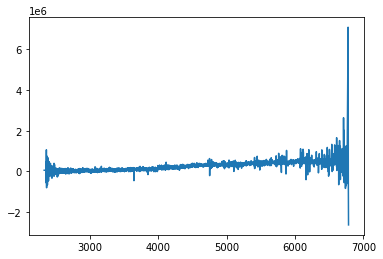

0.768068 2 0.768068


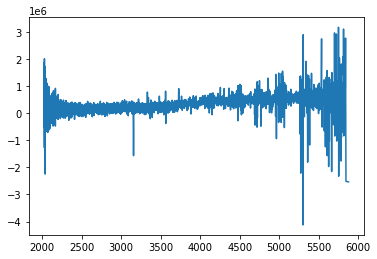

0.658559 2 0.658559


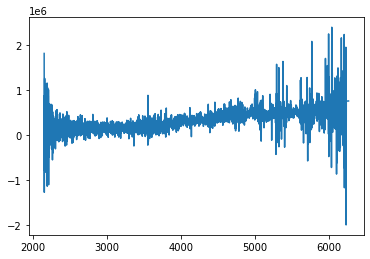

0.63136345 2 0.63136345


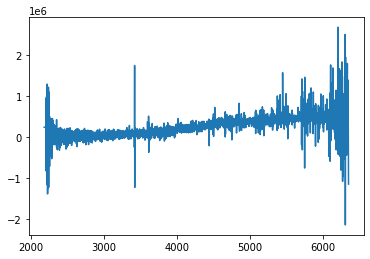

In [23]:
# all pixels are the same size, just padding thegrid, such that they are all on grids of the same length

ii          = 0
min_wl      = 8
max_wl      = -8
num_npixs   = []
img_coeffs1 = []
img_coeffs2 = []
factors     = []
min_z       = 5
max_z       = -5
redshifts   = []

for image in tfds.as_numpy(ds):
    log10wl = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    if de_redshift:
        log10wl = log10wl-np.log10(1+image['redshift'])
    if max(log10wl)>max_wl:
        max_wl= max(log10wl)
    if min(log10wl)<min_wl:
        min_wl=min(log10wl)
    if image['redshift']>max_z:
        max_z = image['redshift']
    if image['redshift']<min_z:
        min_z = image['redshift']
    if image['coeffs'][2] not in num_npixs:
        num_npixs.append(image['coeffs'][2][0])
        img_coeffs1.append(image['coeffs'][1][0])
    if image['coeffs'][0] not in img_coeffs2:
        img_coeffs2.append(image['coeffs'][0][0])
    if ii<10:
        print(image['redshift'], image['label'],image['redshift'])
        factor = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
        plt.plot(10**log10wl,image['flux'][:,0]*10**log10wl*factor)
        plt.show()
        ii+=1
    redshifts.append(image['redshift'])
wl_range = (min_wl, max_wl) 

In [24]:
wl_range

(3.2492131489322817, 3.8708859005835703)

In [25]:
[10**wl_range[ii] for ii in range(2)]

[1775.0604553679134, 7428.2395486320775]

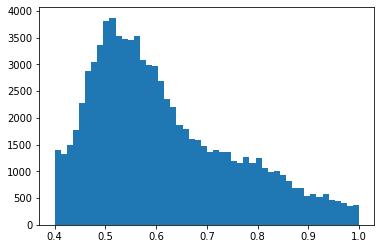

In [26]:
_ = plt.hist(redshifts, bins=50)

In [27]:
# if de_redshift:
#     wl_range = (3.0767948239359755, 4.021900037056991)
# else:
#     wl_range = (3.549499988555908, 4.017199898218678)

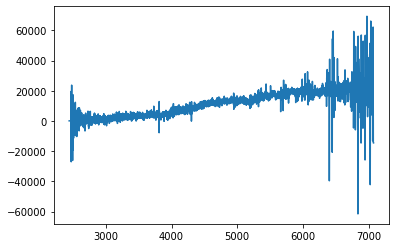

In [28]:
plt.plot(10**log10wl,image['flux'][:,0]*10**log10wl)

In [29]:
print(len(num_npixs))

62


In [30]:
num_npixs = np.sort(np.asarray(num_npixs))

In [31]:
np.unique(img_coeffs1), np.unique(img_coeffs2)

(array([1.e-04], dtype=float32),
 array([3.5495, 3.5501, 3.5502, 3.5504, 3.5505, 3.5506, 3.5507, 3.5508,
        3.5509, 3.551 , 3.5511, 3.5512, 3.5513, 3.5514, 3.5515, 3.5516,
        3.5517, 3.5518, 3.5519, 3.552 , 3.5521, 3.5522, 3.5523, 3.5524,
        3.5525, 3.5526, 3.5527, 3.5529, 3.553 , 3.5531, 3.5532, 3.5533,
        3.5534, 3.5535, 3.5536, 3.5537, 3.5539, 3.554 , 3.5541, 3.5542,
        3.5543, 3.5544, 3.5545, 3.5546, 3.5548, 3.5549, 3.555 , 3.5551,
        3.5552, 3.5553, 3.5555, 3.5561, 3.5564, 3.5565, 3.5566, 3.5567],
       dtype=float32))

In [32]:
num_npixs

array([4586., 4589., 4591., 4592., 4595., 4600., 4603., 4605., 4606.,
       4607., 4608., 4609., 4610., 4611., 4612., 4613., 4615., 4616.,
       4618., 4619., 4622., 4624., 4625., 4629., 4630., 4631., 4632.,
       4634., 4635., 4636., 4637., 4638., 4639., 4641., 4642., 4643.,
       4644., 4645., 4646., 4647., 4648., 4649., 4650., 4651., 4652.,
       4653., 4654., 4655., 4656., 4657., 4658., 4659., 4660., 4661.,
       4662., 4663., 4664., 4665., 4666., 4667., 4668., 4670.],
      dtype=float32)

In [33]:
# compute number of pixels that span entire wl range:
npix_max = (wl_range[1]-wl_range[0])/np.unique(img_coeffs1)
print(npix_max)

[6216.7275]


In [34]:
ind_mask1 = np.floor((np.log10(5560)-wl_range[0])/np.unique(img_coeffs1)).astype('int')

In [35]:
ind_mask2 = np.ceil((np.log10(5590)-wl_range[0])/np.unique(img_coeffs1)).astype('int')

In [36]:
ind_mask1, ind_mask2

(array([4958]), array([4982]))

In [37]:
line_index=np.arange(ind_mask1, ind_mask2)

In [38]:
from scipy.interpolate import interp1d

In [39]:
fixed_num_bins = 500

new_wl = np.linspace(10**wl_range[0],10**wl_range[1],fixed_num_bins)

In [40]:
data_sample = ds.take(2000)

In [41]:
data_sample

<TakeDataset shapes: {and_mask: (None, 1), coeffs: (3, 1), filename: (), flux: (None, 1), inv_var: (None, 1), label: (), redshift: ()}, types: {and_mask: tf.int32, coeffs: tf.float32, filename: tf.string, flux: tf.float32, inv_var: tf.float32, label: tf.int64, redshift: tf.float32}>

In [49]:
new_fluxes =[]
new_fluxes_detrend = []
noises = []
masks = []
params =[]

rescale = 6e6

for image in tfds.as_numpy(ds):
        
    log10wl  = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])-np.log10(1+image['redshift'])
    log10wl  = log10wl
    wl       = 10**log10wl

    # flux
    factor   = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
    flux     = (image['flux'][:,0]*factor)*wl
    
    lines_wl       = (5500,5600)/(1+image['redshift'])
    lines_ind      = np.digitize([lines_wl[0],lines_wl[1]],wl)
    lines_ind      = np.arange(lines_ind[0],lines_ind[1])
    ### mask
    ## conservative mask
    mask           = np.squeeze(image['and_mask'])
    mask2          = np.ones(mask.shape)
    mask2[lines_ind]= 0.
    flux           = flux*(mask*mask2)/rescale
    
    interp   = interp1d(x=wl,y=flux,bounds_error=False, fill_value=0.,kind='linear')
    new_flux = interp(new_wl)
    new_fluxes.append(new_flux)
    
    kernel_size    = 10
    kernel         = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(flux, kernel, mode='same')
    
    interp         = interp1d(x=wl,y=data_convolved,bounds_error=False, fill_value=0.,kind='linear')
    x1_,x2_,x3_    = wl[0]+250, (wl[-1]+wl[0])/2, wl[-1]-250
    x1,x2,x3       = np.digitize([x1_,x2_,x3_],new_wl)
    y1, y2, y3     = interp([x1_,x2_,x3_])
    a              = (x1*(y3-y2)+x2*(y1-y3)+x3*(y2-y1))/((x1-x2)*(x1-x3)*(x2-x3))
    b              = ((y2-y1)-a*(x2**2+x1**2))/(x2-x1)
    c              = y1-a*x1**2-b*x1
    begin,end      = np.digitize([wl[0],wl[-1]],new_wl)
    trend          = a*np.arange(begin,end)**2+b*np.arange(begin,end)+c
    trend          = np.concatenate((np.zeros((begin)),trend,np.zeros((fixed_num_bins-end))))
    new_flux       = new_flux - trend
    
    params.append([a,b,c,image['redshift']])
    
    new_fluxes_detrend.append(new_flux)
    


    
    

    ### noise 
    N              = np.diff(np.digitize(new_wl, wl))
    N[np.where(N==0)] = 1
    N              = np.append(N,1)
    noise_         = np.squeeze(image['inv_var'])
    noise_         = noise_*mask
    ind            = np.where(noise_!=0)
    noise          = np.zeros(noise_.shape, dtype=np.float32)
    noise[ind]     = np.sqrt(1./noise_[ind])*wl[ind]*factor/rescale
    interp         = interp1d(x=wl,y=noise**2,bounds_error=False, fill_value=0.,kind='linear')
    noise          = np.zeros(new_wl.shape)
    noise_         = interp(new_wl)#/N
    ind            = np.where(noise_!=0)
    noise[ind]     = 1./noise_[ind]
    noises.append(noise)
    

    interp         = interp1d(x=wl,y=mask,bounds_error=False, fill_value=0.)
    mask           = interp(new_wl)
#     ind            = np.digitize(wl[ind],new_wl)
#     mask[ind]      = 0.
    masks.append(mask)
    
    
    

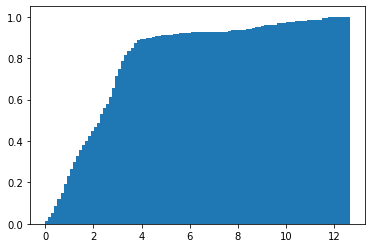

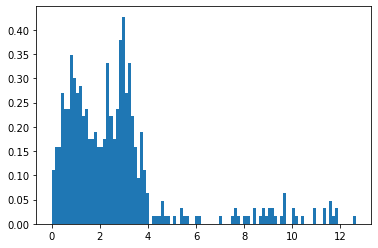

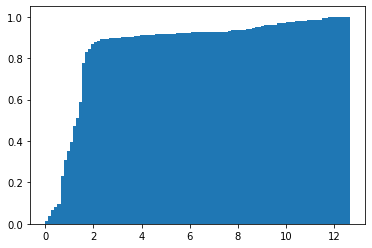

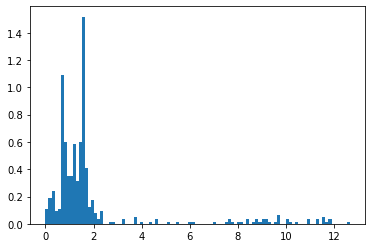

In [51]:
_=plt.hist(np.log10(np.std((np.asarray(new_fluxes_detrend)**2*np.asarray(noises)),axis=0)+1),bins=100, density=True, cumulative=True)
plt.show()
_=plt.hist(np.log10(np.std((np.asarray(new_fluxes_detrend)**2*np.asarray(noises)),axis=0)+1),bins=100, density=True, cumulative=False)
plt.show()

_=plt.hist(np.log10(np.std((np.asarray(new_fluxes)**2*np.asarray(noises)),axis=0)+1),bins=100, density=True, cumulative=True)
plt.show()
_=plt.hist(np.log10(np.std((np.asarray(new_fluxes)**2*np.asarray(noises)),axis=0)+1),bins=100, density=True, cumulative=False)
plt.show()

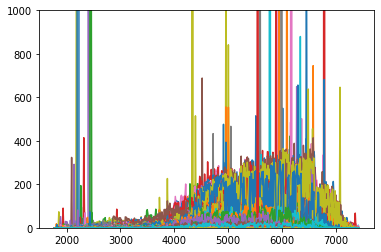

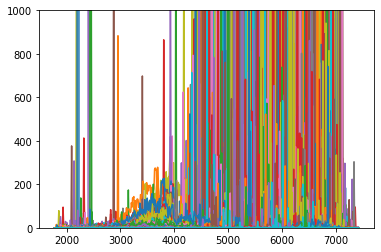

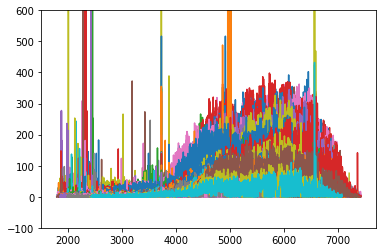

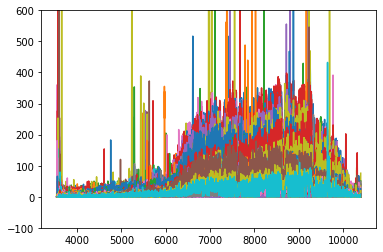

In [55]:
ind1 = 0
ind2 = 500

# for ii in range(10):
#     #plt.plot(np.arange(1000),new_fluxes[ii])
#     plt.errorbar(new_wl[ind1:ind2],(new_fluxes_detrend[ii]*masks[ii])[ind1:ind2],yerr= np.sqrt(1./noises[ii])[ind1:ind2],ecolor='red')
#     #plt.ylim(-1e6,6e6)
# plt.show()

for ii in range(3000):
    #plt.plot(np.arange(1000),new_fluxes[ii])
    plt.errorbar(new_wl[ind1:ind2],((new_fluxes[ii])**2*noises[ii])[ind1:ind2])#,yerr= np.sqrt(1./noises[ii])[ind1:ind2],ecolor='red')
    plt.ylim(0,1000)
plt.show()
#print(np.mean(((new_fluxes_detrend[ii]*masks[ii])**2*noises[ii])))

for ii in range(3000):
    #plt.plot(np.arange(1000),new_fluxes[ii])
    plt.errorbar(new_wl[ind1:ind2],((new_fluxes_detrend[ii])**2*noises[ii])[ind1:ind2])#,yerr= np.sqrt(1./noises[ii])[ind1:ind2],ecolor='red')
    plt.ylim(0,1000)
plt.show()


ind1 = 0
ind2 = -1

for dd in data_sample:
    #plt.plot(np.arange(1000),new_fluxes[ii])
    ww = dd['coeffs'][0][0] + dd['coeffs'][1][0] * np.arange(dd['coeffs'][2][0])-np.log10(1+dd['redshift'])
    ww = 10**ww
    plt.plot(ww[ind1:ind2],((np.squeeze(dd['flux'])*np.squeeze(dd['and_mask']))**2*np.squeeze(dd['inv_var']))[ind1:ind2])
    plt.ylim(-1e2,6e2)
#plt.ylim(0,500)
plt.show()

for dd in data_sample:
    #plt.plot(np.arange(1000),new_fluxes[ii])
    ww = dd['coeffs'][0][0] + dd['coeffs'][1][0] * np.arange(dd['coeffs'][2][0])
    ww = 10**ww
    plt.plot(ww[ind1:ind2],((np.squeeze(dd['flux'])*np.squeeze(dd['and_mask']))**2*np.squeeze(dd['inv_var']))[ind1:ind2])
    plt.ylim(-1e2,6e2)
#plt.ylim(0,500)
plt.show()

# for dd in data_sample:
#     #plt.plot(np.arange(1000),new_fluxes[ii])
#     ww = dd['coeffs'][0][0] + dd['coeffs'][1][0] * np.arange(dd['coeffs'][2][0])-np.log10(1+dd['redshift'])
#     ww = 10**ww
#     plt.plot(ww[ind1:ind2],np.squeeze(dd['flux']*ww)[ind1:ind2])
# plt.show()
    
# plt.plot(new_wl,np.mean(np.asarray(new_fluxes_detrend)*np.asarray(masks),axis=0))
# plt.plot(new_wl,np.mean(np.asarray(new_fluxes_detrend),axis=0))
# plt.ylim(-0.1,0.1)

#     plt.plot(np.linspace(10**wl_range[0],10**wl_range[1],1000)[600:650],new_fluxes[ii][600:650])
    #plt.ylim(-1e6,6e6)
#    plt.show()



    #plt.ylim(-1e6,6e6)
#    plt.show()

In [56]:
len(masks)

85829

In [57]:
# computing padding to align all spectra in wavelength
# log10 wl_min = c0-c1*pad_left  - log10(1+z)
# log10 wl_max = c0+c1*npix+c1*pad_right - log10(1+z)

In [58]:
log10=np.log(10)

In [59]:
# # mask (inverse noise weight or add noise) -> padding (takes care of de-redshifting)

# def preprocessing(d, de_redshift, dlum, extra_mask, downsample, factor, detrend, rescale, scale, line_index, avg_mask, extra_padding, pad):
    
#     data                   = d['flux']
#     noise                  = d['inv_var']  
     
#     if dlum:
#         log10wl            = tf.expand_dims(d['coeffs'][0][0] + d['coeffs'][1][0] * tf.range(d['coeffs'][2][0]),-1)
#         dlum               = tfp.math.interp_regular_1d_grid(x=d['redshift'], x_ref_min=0, x_ref_max=4, y_ref=yref)
#         ff                 = (dlum/ld_ref)**2
#         data               = (data*tf.pow(10.,log10wl))/ff
#         noise              = 1./tf.square(tf.sqrt(1./d['inv_var'])*tf.pow(10.,log10wl)/ff)   
        
#     if detrend:
#         npix           = tf.cast(d['coeffs'][2][0], tf.int32)
#         scale          = 125
#         smooth_flux    = tf.squeeze(AveragePooling1D(scale,scale,'VALID',data_format="channels_last")(data[None,...]))
#         y              = tf.gather(smooth_flux,[3, (npix//2)//scale,npix//scale-3])
#         x1             = tf.cast(scale*3, tf.float32)
#         x2             = tf.cast(npix//2, tf.float32)
#         x3             = tf.cast(npix-scale*3, tf.float32)
#         a              = (x1*(y[2]-y[1])+x2*(y[0]-y[2])+x3*(y[1]-y[0]))/((x1-x2)*(x1-x3)*(x2-x3))
#         b              = ((y[1]-y[0])-a*(x2**2+x1**2))/(x2-x1)
#         c              = y[0]-a*x1**2-b*x1
#         data           = data -(a*tf.range(npix, dtype=tf.float32)**2+b*tf.range(npix, dtype=tf.float32)+c)[...,None]
#     else:
#         a              = 0
#         b              = 0
#         c              = 0
#         smooth_flux    = data
        
#     if de_redshift:
#         pad_left       = (d['coeffs'][0][0]-tf.math.log(1.+d['redshift'])/log10-wl_range[0])/(d['coeffs'][1][0])
#         pad_right      = (wl_range[1]+ tf.math.log(1.-d['redshift'])/log10-d['coeffs'][0][0])/(d['coeffs'][1][0])
#     else:
#         pad_left       = (wl_range[0]-d['coeffs'][0][0])/(-d['coeffs'][1][0])
#         pad_right      = (wl_range[1]-(d['coeffs'][1][0]*d['coeffs'][2][0]+d['coeffs'][0][0]))/(d['coeffs'][1][0])
    
    
#     ## padding to bring everything to the same length
#     pad_left       = tf.maximum(tf.math.round(pad_left),0)    
#     pad_right      = tf.maximum(tf.math.round(pad_right),0)

#     if tf.math.less(pad_left+pad_right+d['coeffs'][2][0],tf.cast(npix_max, dtype=tf.float32)):
#         if tf.math.greater(pad_right,pad_left):
#             pad_left=pad_left+1
#         else:
#             pad_right=pad_right+1
            
#     if tf.math.less(tf.cast(npix_max, dtype=tf.float32), pad_left+pad_right+d['coeffs'][2][0]):
#         if tf.math.greater(pad_right,pad_left):
#             pad_right=pad_right-1
#         else:
#             pad_left=pad_left-1
    
#     pad_left       = tf.cast(pad_left,tf.int32)
#     pad_right      = tf.cast(pad_right,tf.int32)
    
#     padded         = tf.pad(data, [[pad_left,pad_right],[0,0]])
#     padded_mask    = tf.pad(tf.cast(d['and_mask'],tf.float32), [[pad_left,pad_right],[0,0]])
#     padded_noise   = tf.pad(noise, [[pad_left,pad_right],[0,0]])
    
#     if extra_mask:
#         indices        = tf.constant(line_index,dtype=tf.int64)
#         sparse         = tf.SparseTensor(indices, np.repeat(0.,25) , tf.cast((npix_max,1),tf.int64))
#         sparse         = tf.sparse.to_dense(sparse, default_value=1, validate_indices=True)
#         padded_mask    = padded_mask*tf.cast(sparse,tf.float32)
        
#     flux               = tf.ensure_shape(padded,(npix_max,1))
#     padded_mask        = tf.ensure_shape(padded_mask,(npix_max,1))
#     padded_noise       = tf.ensure_shape(padded_noise,(npix_max,1))
#     npix               = npix_max
    
#     if downsample:
#         flux           = tf.squeeze(AveragePooling1D(factor,factor,'same',data_format="channels_last")(flux[None,...]))
#         npix           = npix_max//factor+1
#         flux           = tf.expand_dims(flux,1)
#         if avg_mask:
#             padded_mask = tf.squeeze(AveragePooling1D(factor,factor,'same',data_format="channels_last")(padded_mask[None,...]))
#         else:
#             padded_mask = tf.squeeze(MaxPooling1D(factor,factor,'same',data_format="channels_last")(padded_mask[None,...]))
#         padded_mask = tf.expand_dims(padded_mask,1)
        
#         nn            = tf.where(padded_noise>0,padded_noise,100)
#         noise         = tf.squeeze(AveragePooling1D(factor,factor,'same',data_format="channels_last")(1./nn[None,...]))
#         inv_noise     = 1./(noise/factor)
#         inv_noise     = tf.expand_dims(inv_noise,1)

#         padded_noise  = tf.where(inv_noise!=100*factor,inv_noise,0)
#         padded_noise  = tf.ensure_shape(inv_noise,(npix,1))
        
#     else:
#         factor         = 1 
        
#     if rescale: 
#         flux           = flux/scale
#         padded_noise   = padded_noise*scale**2
    
#     if extra_padding:
#         flux          = tf.pad(flux, [[0,pad],[0,0]])
#         padded_mask   = tf.pad(padded_mask, [[0,pad],[0,0]])
#         padded_noise  = tf.pad(padded_noise, [[0,pad],[0,0]])
        
        
#     return dict(flux=flux, smooth_flux=smooth_flux, mask=padded_mask,  inverse=padded_noise, detrend=[tf.squeeze(d['redshift']),a,b,c])
    

In [60]:
#prep_data = ds.map(lambda x, de_redshift=de_redshift, dlum=False, extra_mask=False, downsample=True, factor=5, detrend=True, rescale=True, scale=10, line_index=None, avg_mask = False, extra_padding=False, pad=5: preprocessing(x, de_redshift, dlum, extra_mask, downsample, factor, detrend, rescale, scale, line_index, avg_mask,extra_padding=extra_padding, pad=pad))

In [61]:
#prep_data

In [62]:
# ind1 = 600
# ind2 = 700
# shapes = []
# wls = 10**np.linspace(min_wl,max_wl,npix_max)
# for ii, image in enumerate(tfds.as_numpy(prep_data)):
#     if ii in np.arange(10):
# #        plt.axvline(5560)
# #        plt.axvline(5590)
# #         plt.plot(image['flux'])
# #         plt.plot(image['mask']*image['flux'])
#         plt.errorbar(np.arange(len(image['flux'])),image['flux']*image['mask'],yerr=np.sqrt(1./np.squeeze(image['inverse'])),ecolor='red')
#         plt.show()
        
#         plt.errorbar(np.arange(len(image['flux']))[ind1:ind2],(image['flux']*image['mask'])[ind1:ind2],yerr=np.sqrt(1./np.squeeze(image['inverse']))[ind1:ind2],ecolor='red')
#         plt.show()
# #         print(np.sqrt(1/np.squeeze(image['inverse']))[0:50])
# #         print(image['flux'][0:10])
# #        plt.ylim(-10,10)
#     plt.show()
#     if ii==10:
#         break

In [63]:
# shapes = []
# wls = 10**np.linspace(min_wl,max_wl,npix_max)
# for ii, image in enumerate(tfds.as_numpy(prep_data)):
#     if ii in np.arange(10):
#         plt.axvline(5560)
#         plt.axvline(5590)
#         plt.plot(wls,image['flux'])
#         plt.plot(wls,image['flux']*image['mask'])
#         plt.plot(wls[::125][1:],np.squeeze(image['smooth_flux']))
#         a,b,c, d = image['detrend']
#         print(d.shape)
#         plt.plot(wls,a*np.arange(npix_max)**2+b*np.arange(npix_max)+c)
#         plt.show()
#         plt.plot(wls,np.squeeze(image['flux'])+(a*np.arange(npix_max)**2+b*np.arange(npix_max)+c))
#         plt.show()
#         plt.plot(wls,np.squeeze(np.sqrt(1/image['inverse'])))
#         plt.show()
#     if image['flux'].shape not in shapes:
#         shapes.append(image['flux'].shape)
#     if ii>10:
#         break
#     plt.show()

In [64]:
latent_dim = 10
dim        = 500

In [65]:
network_type='fully_connected'

In [66]:
from tensorflow.keras.layers import concatenate as concat

In [89]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask


input        = Input(shape=(dim))
input_params = Input(shape=(4))
input_mask   = Input(shape=(dim))
input_noise  = Input(shape=(dim))




if network_type=='fully_connected':
# simplest, not many architectural choices other than number of neurons, likely to overfit
    #encoder_input = input#tf.concat([input,tf.tile(input_z,[tf.shape(input)[0],1])], axis=1)
#     x = Reshape((dim,))(input)
#    x = tf.concat([input,input_params],axis=1)
    x = Dense(256)(input)
    x = BatchNormalization()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(latent_dim)(x)  
    #x = tf.concat([x,input_params],axis=1)
    #x = tf.concat([input_params,x], axis=1)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dense(dim)(x)
    #x = Reshape((dim))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(32, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(32, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    y = Flatten()(x)
    x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    z = LeakyReLU()(x)
    x = tf.concat([z,input_params], axis=1)
    x = Dense(30*32,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((30,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = tf.keras.layers.ZeroPadding1D(padding=[0,1])(x)
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    #x, _ = Lambda( lambda x: tf.split(x,num_or_size_splits=(dim,1),axis=1))(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
    x = Reshape((dim,1))(x)
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(loss)
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}



def custom_metric(y_true, y_pred):
    loss = tf.math.square(y_true[0]-y_pred)*y_true[3]
    valid_loss = tf.reduce_mean(loss*tf.boolean_mask(loss,y_true[2]))
    return valid_loss
    
    
    
lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=['mse'],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          128256      input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 256)          1024        dense_8[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          32896       batch_normalization_6[0][0]      
_____________________________________________________________________________________

In [90]:
# from tensorflow.keras.layers.experimental import preprocessing

# layer_normalize = preprocessing.Normalization()
# layer_normalize.adapt(prep_data.map(lambda x: x['flux']))

In [91]:
# for i, l in enumerate(lstm_ae.layers):
#     print(f'layer {i}: {l}')
#     print(f'has input mask: {l.input_mask}')
#     print(f'has output mask: {l.output_mask}')

In [92]:
BATCH_SIZE   = 256

# train_size   = int(0.6 * DATASET_SIZE)
# test_size    = int(0.2 * DATASET_SIZE)
# valid_size   = int(0.2 * DATASET_SIZE)

# train_dataset = prep_data.take(train_size).repeat().map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),x['flux'])).batch(BATCH_SIZE)
# test_dataset  = prep_data.skip(train_size).take(test_size).map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)
# valid_dataset = prep_data.skip(train_size+test_size).take(valid_size).map(lambda x:((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)


In [93]:
np.asarray(new_fluxes_detrend[0:50000]).shape

(50000, 500)

In [94]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [95]:
train_data = np.asarray(new_fluxes)[:60000]
valid_data = np.asarray(new_fluxes)[60000:]
train_mask = np.asarray(masks)[:60000]
valid_mask = np.asarray(masks)[60000:]
train_noise = np.asarray(noises)[:60000]
valid_noise = np.asarray(noises)[60000:]
train_params = np.asarray(params)[:60000]
valid_params = np.asarray(params)[60000:]

In [96]:
len(params)

85829

In [97]:
history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_params), y=None, batch_size=BATCH_SIZE, epochs=100, callbacks=[callback])

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22824044.5888
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22824425.0314
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22870221.3248
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22851188.2582
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22911393.4184
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22826608.2998
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - training_loss: 23015761.9032
Epoch 8/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22823763.3552
Epoch 9/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22822045.5028
Epoch 10/100
235/235 [==============================] - 1s 3ms/step - training_loss: 22820368.7648
Epoch 11/100
235/23

In [98]:
history.history['training_loss']

[526.986328125,
 683.8140258789062,
 1501.9444580078125,
 2463.354248046875,
 1094.885009765625,
 817.673828125,
 26328884.0,
 1049.7999267578125,
 1718.768798828125,
 2295.076904296875,
 1698.0926513671875,
 387975264.0,
 2220.434814453125,
 1168.6295166015625,
 2076.9326171875,
 1989.5360107421875,
 1886.3013916015625,
 105619536.0,
 1359.171875,
 1232.06396484375,
 1193.446044921875,
 1782.6373291015625,
 1215.369873046875,
 1786.497314453125,
 2086.232421875,
 1918.960693359375,
 1607.29052734375,
 1628.8974609375,
 1766.2120361328125,
 2036.142333984375,
 1156.9976806640625,
 1670.93603515625,
 1363.5760498046875,
 1956.52734375,
 1520.57763671875,
 1183.349853515625,
 1693.740478515625,
 1132.5938720703125,
 1509.4693603515625,
 1265.480712890625,
 1455948.75,
 1329.34521484375,
 1237.160888671875,
 1220.3389892578125,
 387915104.0,
 1263.057861328125,
 877.2685546875,
 1119.30322265625,
 2205.791259765625,
 634.14501953125,
 722.6429443359375,
 1031.065673828125,
 1086.658691406

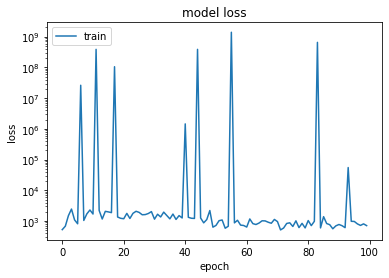

In [99]:
plt.semilogy(history.history['training_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [100]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix + 1):
        curr_layer = main_model.get_layer(index=ix)
        new_model.add(curr_layer)
    return new_model

In [101]:
data = np.asarray(new_fluxes)

In [102]:
data[0].shape

(500,)

In [103]:
recon_train   = lstm_ae.predict(data[:512])
recon_test    = lstm_ae.predict(data[512:1024])

In [104]:
# encoder = extract_layers(lstm_ae, 1, 16)
# encoded = encoder.predict(valid_dataset.take(1))


In [105]:
# encoded.shape

In [106]:
# decoder = extract_layers(lstm_ae, 18, -1)
# print(encoded.shape)

In [107]:
# decoder.predict(encoded).shape

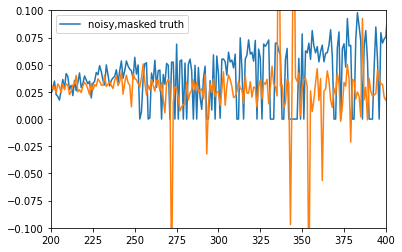

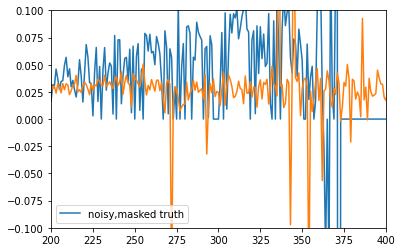

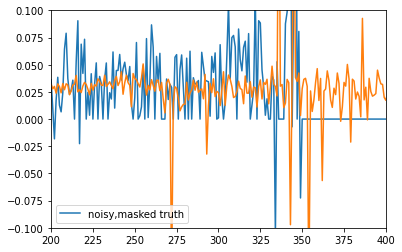

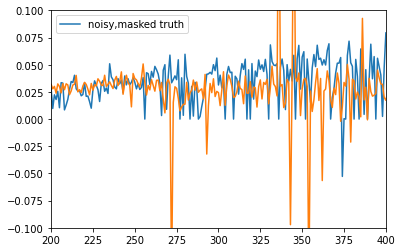

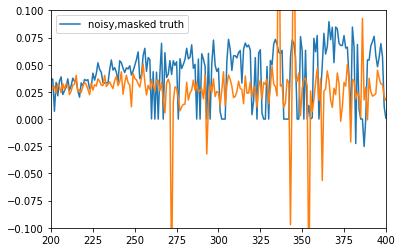

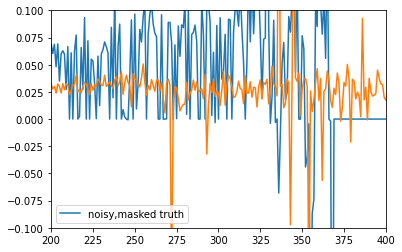

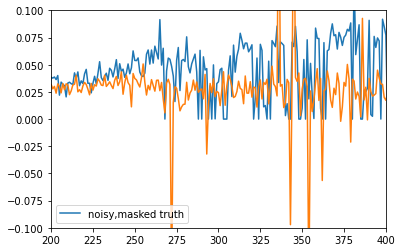

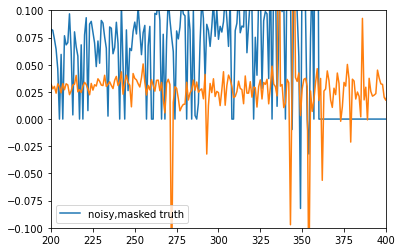

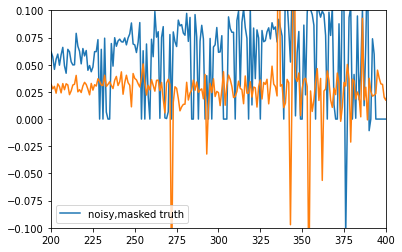

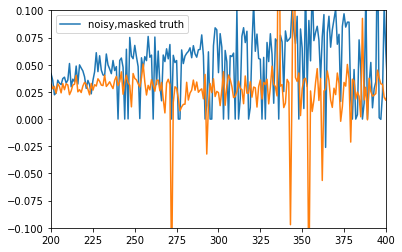

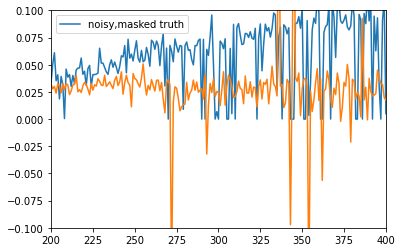

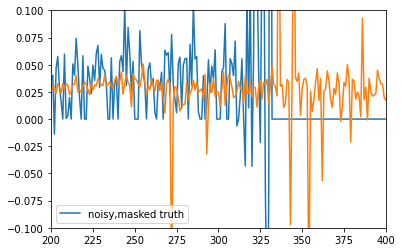

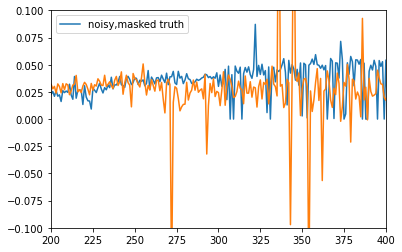

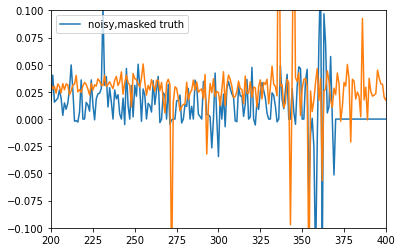

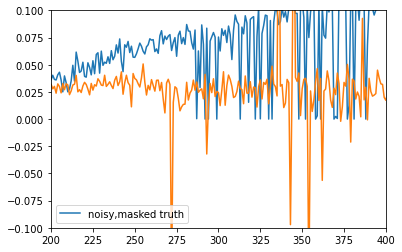

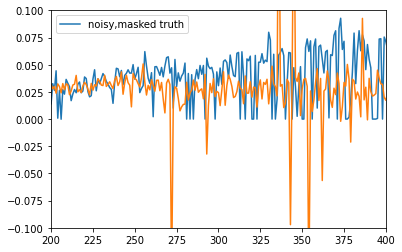

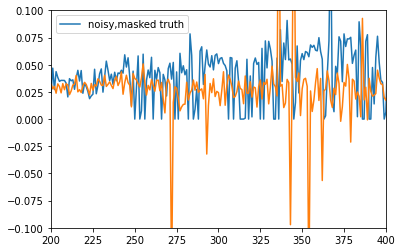

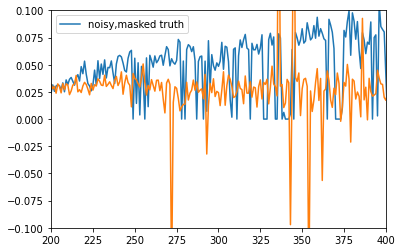

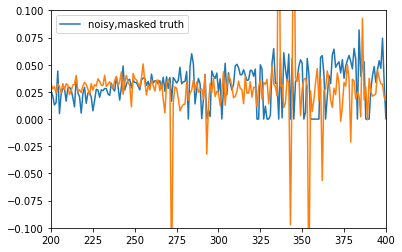

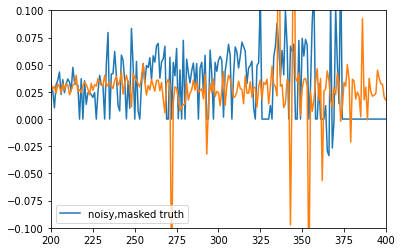

In [108]:

for ii in range(20):
    plt.plot(data[ii]*masks[ii],label='noisy,masked truth')
    #errs = np.zeros(npix_max, np.int32)
    #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
    plt.errorbar(np.arange(dim),recon_train[ii])#,yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
    plt.ylim(-0.1,0.1)
    plt.xlim(200,400)
    plt.legend()
    plt.show()
#     plt.plot(np.arange(dim)[600:700],train[0][0][ii][600:700],label='noisy,masked truth')
#     plt.errorbar(np.arange(dim)[600:700],recon_train[ii][600:700],label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
#     plt.legend()
#     plt.show()

In [225]:
for test in test_dataset.take(1):
    for ii in range(20):
        plt.plot(test[0][0][ii],label='noisy,masked truth')
        errs = np.squeeze(np.sqrt(1/test[0][3][ii]))
        print(recon_test[ii].shape, errs.shape)
        plt.errorbar(np.arange(dim),np.squeeze(recon_test[ii]),yerr=errs,label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()

NameError: name 'test_dataset' is not defined